In [1]:
import pandas as pd
import numpy as np

,timestamps,windspeed_10m,winddirection_10m,sun_flat,sun_tilt
0,1661133600,8.29,228.0,0.0,0.0
1,1661137200,8.50,229.0,0.0,0.0
2,1661140800,8.75,231.0,0.0,0.0
3,1661144400,8.84,232.0,0.0,0.0
4,1661148000,9.28,228.0,0.0,0.0
...,...,...,...,...,...
91,1661461200,6.46,112.0,42.0,282.9
92,1661464800,6.24,112.0,0.0,0.0
93,1661468400,6.15,112.0,0.0,0.0
94,1661472000,5.78,113.0,0.0,0.0


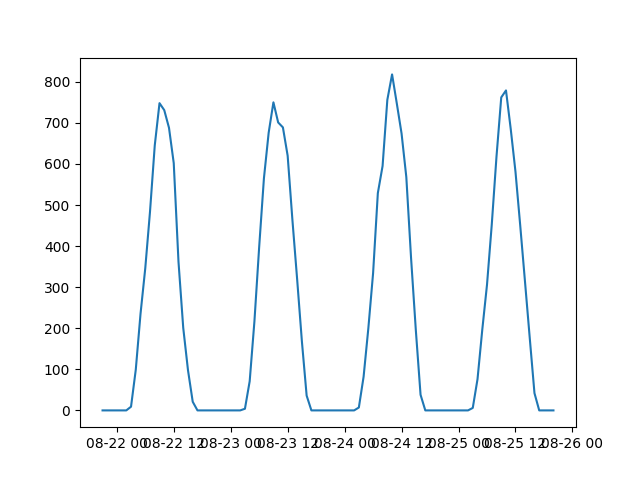

In [147]:
import requests
from datetime import datetime
from timezonefinder import TimezoneFinder
import matplotlib.pyplot as plt
%matplotlib widget

to_dates = np.vectorize(datetime.fromtimestamp)
tzfinder = TimezoneFinder()

def get_wind_solar(latitude, longitude, start:datetime, stop:datetime):

    vars = [
        'shortwave_radiation',      #total sun for horizontal array 
        'direct_normal_irradiance', #used to calculate total sun for tilted array
        'diffuse_radiation',        #used to calculate total sun for tilited array (add to direct)
        'windspeed_10m',
        'winddirection_10m',
    ]

    #get timezone at coordinate so timestamps make sense
    timezone = tzfinder.timezone_at(lat=latitude, lng=longitude)

    forecast = {}
    for var in vars:

        response = requests.request(
            method = "GET", 
            url = "https://api.open-meteo.com/v1/forecast?", 
            params = {
                "latitude": latitude,
                "longitude": longitude,
                "hourly": var,
                "windspeed_unit": "ms",
                "start_date": start.strftime("%Y-%m-%d"),
                "end_date": stop.strftime("%Y-%m-%d"),
                "timeformat": "unixtime",
                "timezone": timezone
            }
        ).json()
        
        try:
            values = response['hourly'][var]
            timestamps = response['hourly']['time']
        except Exception as e:
            print(f"Error: {e} \n {response}")

        while values and values is None:    #remove trailing Nones
            values[var].pop()

        if('dates' not in forecast):
            forecast['timestamps'] = timestamps[:len(values)] #truncate timestamps to match values
        forecast[var] = values

    if('direct_normal_irradiance' in forecast and 'diffuse_radiation' in forecast):
        forecast['sun_flat'] = forecast['shortwave_radiation']
        forecast['sun_tilt'] = [sum(x) for x in zip(forecast['direct_normal_irradiance'], forecast['diffuse_radiation'])]

        del forecast['shortwave_radiation']
        del forecast['direct_normal_irradiance']
        del forecast['diffuse_radiation']
        
    return forecast


import pandas as pd
df = pd.DataFrame.from_dict(get_wind_solar(40.11, -33, datetime(2022, 8, 22, hour=12), datetime(2022, 8, 25, hour=12)))

plt.figure()
plt.plot([datetime.fromtimestamp(t) for t in df.timestamps], df.sun_flat)

df
